<a href="https://colab.research.google.com/github/SethupathyM/Unsupervised_ML_Clustering_and_Sentiment_Analysis_Zomato_Restaurant/blob/main/Zomato_Restaurant_Clustering_and_Sentiment_Analysis_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Problem Statement**

Zomato is an Indian restaurant aggregator and food delivery start-up founded by Deepinder Goyal and Pankaj Chaddah in 2008. Zomato provides information, menus and user-reviews of restaurants, and also has food delivery options from partner restaurants in select cities.

India is quite famous for its diverse multi cuisine available in a large number of restaurants and hotel resorts, which is reminiscent of unity in diversity. Restaurant business in India is always evolving. More Indians are warming up to the idea of eating restaurant food whether by dining outside or getting food delivered. The growing number of restaurants in every state of India has been a motivation to inspect the data to get some insights, interesting facts and figures about the Indian food industry in each city. So, this project focuses on analysing the Zomato restaurant data for each city in India.

The Project focuses on Customers and Company, you have  to analyze the sentiments of the reviews given by the customer in the data and made some useful conclusion in the form of Visualizations. Also, cluster the zomato restaurants into different segments. The data is vizualized as it becomes easy to analyse data at instant. The Analysis also solve some of the business cases that can directly help the customers finding the Best restaurant in their locality and for the company to grow up and work on the fields they are currently lagging in.

This could help in clustering the restaurants into segments. Also the data has valuable information around cuisine and costing which can be used in cost vs. benefit analysis

Data could be used for sentiment analysis. Also the metadata of reviewers can be used for identifying the critics in the industry. 

# **Attribute Information**

## **Zomato Restaurant names and Metadata**
Use this dataset for clustering part

1. Name : Name of Restaurants

2. Links : URL Links of Restaurants

3. Cost : Per person estimated Cost of dining

4. Collection : Tagging of Restaurants w.r.t. Zomato categories

5. Cuisines : Cuisines served by Restaurants

6. Timings : Restaurant Timings

## **Zomato Restaurant reviews**
Merge this dataset with Names and Matadata and then use for sentiment analysis part

1. Restaurant : Name of the Restaurant

2. Reviewer : Name of the Reviewer

3. Review : Review Text

4. Rating : Rating Provided by Reviewer

5. MetaData : Reviewer Metadata - No. of Reviews and followers

6. Time: Date and Time of Review

7. Pictures : No. of pictures posted with review

In [2]:
# Importing Libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import math

import re, string, unicodedata
import nltk
import inflect
from bs4 import BeautifulSoup
from nltk import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import LancasterStemmer, WordNetLemmatizer

from keras.preprocessing.text import Tokenizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.datasets import make_blobs
from nltk.stem import PorterStemmer, LancasterStemmer

from yellowbrick.cluster import KElbowVisualizer
from wordcloud import WordCloud

import inflect
import scipy.cluster.hierarchy as shc
from sklearn.cluster import AgglomerativeClustering


In [3]:
# Mounting the drive
from google.colab import drive
drive.mount('/content/Mydrive')

Drive already mounted at /content/Mydrive; to attempt to forcibly remount, call drive.mount("/content/Mydrive", force_remount=True).


 **Loading Zomato Restaurant names and Metadata CSV file**

In [4]:
# Loading the CSV file
df = pd.read_csv('/content/Mydrive/MyDrive/Capstone_Project_Unsupervised_ML_Zomato_Restaurant_Clustering_and_Sentiment_Analysis/Zomato Restaurant names and Metadata.csv')

In [5]:
# Shape
df.shape

(105, 6)

In [6]:
# Head
df.head()

,Name,Links,Cost,Collections,Cuisines,Timings
0,Beyond Flavours,https://www.zomato.com/hyderabad/beyond-flavou...,800,"Food Hygiene Rated Restaurants in Hyderabad, C...","Chinese, Continental, Kebab, European, South I...","12noon to 3:30pm, 6:30pm to 11:30pm (Mon-Sun)"
1,Paradise,https://www.zomato.com/hyderabad/paradise-gach...,800,Hyderabad's Hottest,"Biryani, North Indian, Chinese",11 AM to 11 PM
2,Flechazo,https://www.zomato.com/hyderabad/flechazo-gach...,"1,300","Great Buffets, Hyderabad's Hottest","Asian, Mediterranean, North Indian, Desserts","11:30 AM to 4:30 PM, 6:30 PM to 11 PM"
3,Shah Ghouse Hotel & Restaurant,https://www.zomato.com/hyderabad/shah-ghouse-h...,800,Late Night Restaurants,"Biryani, North Indian, Chinese, Seafood, Bever...",12 Noon to 2 AM
4,Over The Moon Brew Company,https://www.zomato.com/hyderabad/over-the-moon...,"1,200","Best Bars & Pubs, Food Hygiene Rated Restauran...","Asian, Continental, North Indian, Chinese, Med...","12noon to 11pm (Mon, Tue, Wed, Thu, Sun), 12no..."


In [7]:
# Info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105 entries, 0 to 104
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Name         105 non-null    object
 1   Links        105 non-null    object
 2   Cost         105 non-null    object
 3   Collections  51 non-null     object
 4   Cuisines     105 non-null    object
 5   Timings      104 non-null    object
dtypes: object(6)
memory usage: 5.0+ KB


In [8]:
# Null values
# Percentage of null values for each features
# print(list(df.columns))

for col in list(df.columns):
  if ((df[col].isnull().sum())/(len(df[col]))*100) > 50:
    # print((df[col].isnull().sum())/(len(df[col]))*100)
    print(col)

# As in the feature 'Collections' more than 50% of the observations are NULL values, so feature 'Collections' is droppped

Collections


In [9]:
# Dropping the 'Collections' feature
df.drop(columns = 'Collections',axis =1,inplace = True)

# Removing the observations with null values in 'Timings' feature
df.dropna(axis = 0,inplace = True)

# Print
print(df.shape)
print(df.info())

(104, 5)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 104 entries, 0 to 104
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Name      104 non-null    object
 1   Links     104 non-null    object
 2   Cost      104 non-null    object
 3   Cuisines  104 non-null    object
 4   Timings   104 non-null    object
dtypes: object(5)
memory usage: 4.9+ KB
None


In [10]:
# Summary
df.describe()

,Name,Links,Cost,Cuisines,Timings
count,104,104,104,104,104
unique,104,104,29,91,77
top,Beyond Flavours,https://www.zomato.com/hyderabad/beyond-flavou...,500,"North Indian, Chinese",11 AM to 11 PM
freq,1,1,13,4,6


In [11]:
# Replacing empty space and comma
df['Cuisines'] = df['Cuisines'].str.replace(' ','')
df['Cuisines'] = df['Cuisines'].str.replace(',',', ')

In [12]:
# Unique Cuisines
print('Number of Unique Cuisines : ',len(df['Cuisines'].unique()))
print(list(df['Cuisines'].unique()))

Number of Unique Cuisines :  91
['Chinese, Continental, Kebab, European, SouthIndian, NorthIndian', 'Biryani, NorthIndian, Chinese', 'Asian, Mediterranean, NorthIndian, Desserts', 'Biryani, NorthIndian, Chinese, Seafood, Beverages', 'Asian, Continental, NorthIndian, Chinese, Mediterranean', 'Seafood, Goan, NorthIndian, Continental, Asian', 'HealthyFood, NorthIndian, Continental, SouthIndian', 'Lebanese', 'American, Chinese, NorthIndian, Kebab, SouthIndian', 'IceCream, Desserts', 'StreetFood, NorthIndian, FastFood', 'Mediterranean, NorthIndian, Kebab, BBQ', 'Continental, American, Chinese', 'NorthIndian, Italian, FingerFood', 'European, Mediterranean, NorthIndian', 'Burger, FastFood', 'NorthIndian', 'Chinese, NorthIndian', 'NorthIndian, Chinese, Continental', 'NorthIndian, Chinese, Biryani', 'NorthIndian, Japanese, Italian, Salad, Sushi', 'American', 'Continental', 'Mexican, Italian, NorthIndian, Chinese, Salad', 'NorthIndian, Mediterranean, European', 'Mughlai, Biryani', 'FastFood', 'B

In [13]:
# Spliiting with 'comma' and empty space
cuisine_list = df.Cuisines.str.split(', ')
# print(cuisine_list)

In [38]:
# Top 10 Cuisines
clusterlist = {}
for names in cuisine_list:
    for name in names:
      # print(name)
      if (name in clusterlist):
        clusterlist[name]+=1
        # print(clusterlist)
      else:
         clusterlist[name]=1
# Create a cuis dataframe
cuis_df = pd.DataFrame(clusterlist.values(),index = clusterlist.keys(),columns = {'Counts of Cuisines Restaurants'}).reset_index()

# Sort the dataframe in ascending order
cuis_df.sort_values(by = 'Counts of Cuisines Restaurants',ascending = False,inplace = True)

#Pick the 10 restaurant most nominated 
top_10_cuis = cuis_df[0:10]

print('The Top 10 Cuisines are:\n',top_10_cuis)

The Top 10 Cuisines are:
           index  Counts of Cuisines Restaurants
5   NorthIndian                              60
0       Chinese                              43
1   Continental                              21
6       Biryani                              16
18     FastFood                              15
7         Asian                              15
20      Italian                              14
9      Desserts                              13
4   SouthIndian                               8
28       Bakery                               7


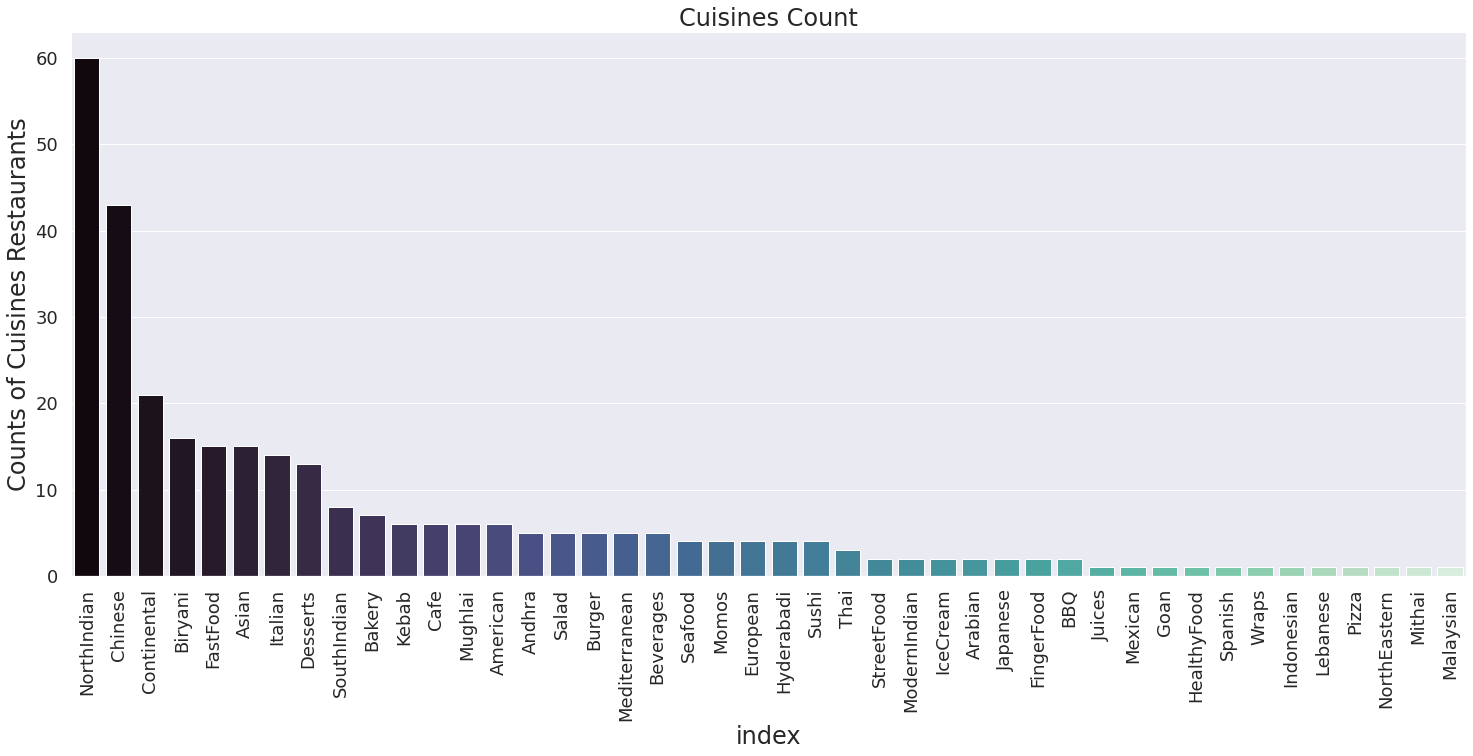

In [39]:
# Visualization of Cuisines Count
plt.figure(figsize = (25, 10))
sns.set(font_scale = 2)
sns.barplot(data = cuis_df,x = cuis_df['index'],y = cuis_df['Counts of Cuisines Restaurants'],palette='mako')
plt.title('Cuisines Count')
plt.xticks(rotation = 90,fontsize = 18)
plt.yticks(fontsize = 18)
plt.show()

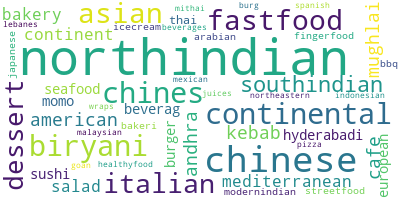

In [123]:
# Visualization of words from 'Cuisines' feature
df['Cuisines']= df['Cuisines'].astype(str)

ps = PorterStemmer() 
df['Cuisines']=df['Cuisines'].map(lambda x: ps.stem(x))
long_string = ','.join(list(df['Cuisines'].values))
long_string
wordcloud = WordCloud(background_color="white", max_words=100, contour_width=3, contour_color='steelblue')
wordcloud.generate(long_string)
wordcloud.to_image()

In [16]:
from wordcloud import WordCloud, STOPWORDS
words_list = clusterlist.keys()
strr = ' '
for i in words_list:
    strr = strr + i + ' '
    
wordcloud = WordCloud(width = 1400, height = 14000,background_color ='ivory',min_font_size = 12).generate(strr) 
  
# plot the WordCloud image                        
plt.figure(figsize = (8, 5), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show()

KeyboardInterrupt: ignored

In [17]:
# Unique Restaurant names
df['Name'].nunique()

104

In [24]:
# 'Cuisine' feature
# Replacing ',' 
df['Cost'] = df['Cost'].str.replace(',','')

# Converting 'cost' feature to integer datatype
df['Cost'] = df['Cost'].apply(lambda x:int(x))

In [33]:
# Creating DataFrame with Restaurant names with respective cost
restaurant_cost = pd.DataFrame(df.groupby('Name').agg({'Cost':'mean'})).reset_index()
restaurant_cost.sort_values(by = 'Cost',ascending = False,inplace= True)
# restaurant_cost.head()

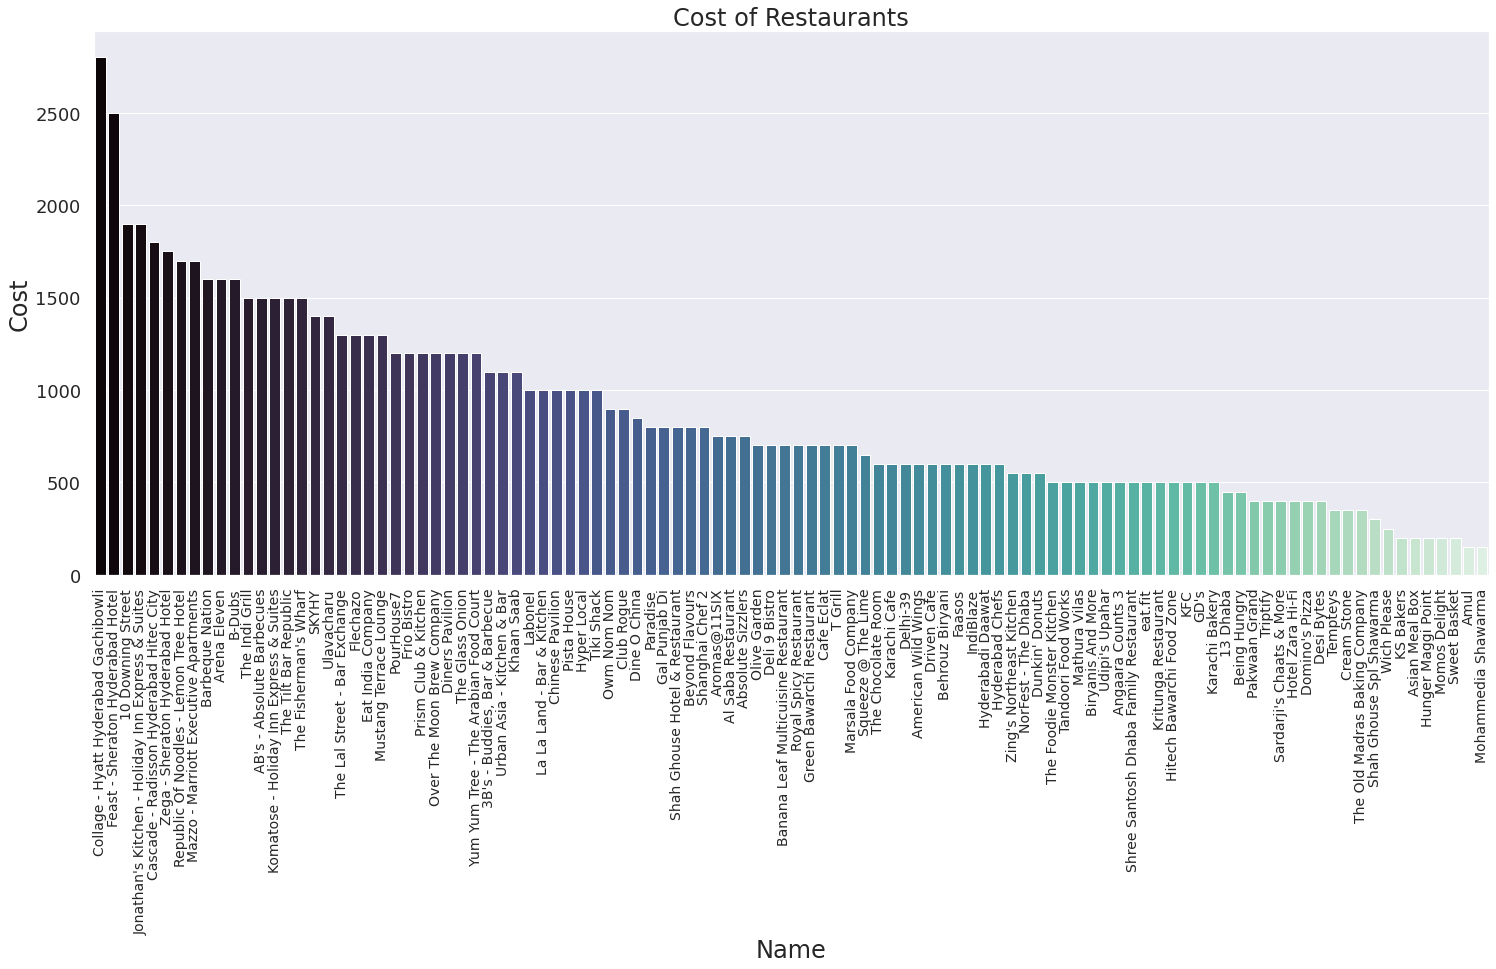

In [40]:
# Visualization of Restaurant names with respective cost
plt.figure(figsize = (25, 10))
sns.set(font_scale = 2)
sns.barplot(data = restaurant_cost,x = restaurant_cost['Name'],y = restaurant_cost['Cost'],palette='mako')
plt.title('Cost of Restaurants')
plt.xticks(rotation = 90,fontsize = 14)
plt.yticks(fontsize = 18)
plt.show()

In [17]:
# Tokenizer
tokenizer = Tokenizer(num_words="MAX_NB_WORDS")
tokenizer.fit_on_texts(df[['Cuisines','Links','Timings']])

In [18]:
# Functions
def remove_non_ascii(words):
    """Remove non-ASCII characters from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = unicodedata.normalize('NFKD', word).encode('ascii', 'ignore').decode('utf-8', 'ignore')
        new_words.append(new_word)
    return new_words

def to_lowercase(words):
    """Convert all characters to lowercase from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = word.lower()
        new_words.append(new_word)
    return new_words

def remove_punctuation(words):
    """Remove punctuation from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = re.sub(r'[^\w\s]', '', word)
        if new_word != '':
            new_words.append(new_word)
    return new_words

def replace_numbers(words):
    """Replace all interger occurrences in list of tokenized words with textual representation"""
    p = inflect.engine()
    new_words = []
    for word in words:
        if word.isdigit():
            new_word = p.number_to_words(word)
            new_words.append(new_word)
        else:
            new_words.append(word)
    return new_words

def stem_words(words):
    """Stem words in list of tokenized words"""
    stemmer = LancasterStemmer()
    stems = []
    for word in words:
        stem = stemmer.stem(word)
        stems.append(stem)
    return stems

def lemmatize_verbs(words):
    """Lemmatize verbs in list of tokenized words"""
    lemmatizer = WordNetLemmatizer()
    lemmas = []
    for word in words:
        lemma = lemmatizer.lemmatize(word, pos='v')
        lemmas.append(lemma)
    return lemmas

def normalize(words):
    words = remove_non_ascii(words)
    words = to_lowercase(words)
    words = remove_punctuation(words)
    words = replace_numbers(words)
    return words

col_lsts = ['Links','Cuisines','Timings']
for col_lst in col_lsts:
  df[col_lst] = normalize(df[col_lst])

In [19]:
df.head()

,Name,Links,Cost,Cuisines,Timings
0,Beyond Flavours,httpswwwzomatocomhyderabadbeyondflavoursgachib...,800,chinese continental kebab european southindian...,12noon to 330pm 630pm to 1130pm monsun
1,Paradise,httpswwwzomatocomhyderabadparadisegachibowli,800,biryani northindian chinese,11 am to 11 pm
2,Flechazo,httpswwwzomatocomhyderabadflechazogachibowli,"1,300",asian mediterranean northindian desserts,1130 am to 430 pm 630 pm to 11 pm
3,Shah Ghouse Hotel & Restaurant,httpswwwzomatocomhyderabadshahghousehotelresta...,800,biryani northindian chinese seafood beverages,12 noon to 2 am
4,Over The Moon Brew Company,httpswwwzomatocomhyderabadoverthemoonbrewcompa...,"1,200",asian continental northindian chinese mediterr...,12noon to 11pm mon tue wed thu sun 12noon to 1...


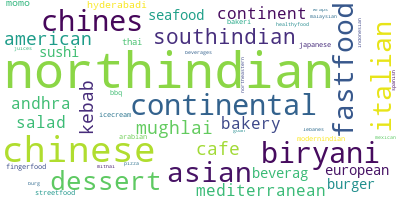

In [21]:
df['Cuisines'].nunique()

91

In [22]:
# Tfidf vectorizer
vectorizer = TfidfVectorizer(stop_words= 'english')

X = vectorizer.fit_transform(df['Cuisines'])

In [23]:
X.shape
# we have 50 unique words

(104, 50)

In [24]:
# Type of X object
type(X)

scipy.sparse.csr.csr_matrix

In [25]:
# Converting 'X' object to array
X = X.toarray()

In [26]:
type(X)

numpy.ndarray

In [27]:
# Elbow method to find appropriate 'K' value

In [28]:
# 'k-means++' would initialize the centroids far from each other because intialize the centroids nearby could lead to improper clustering

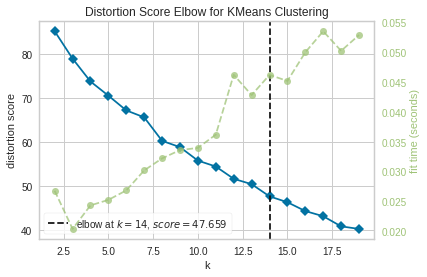

In [29]:
# KElbowvisualizer with metric as 'distortion

model = KMeans(init="k-means++",max_iter=300,random_state=0)
visualizer = KElbowVisualizer(model, k=(2,20),metric= 'distortion', timings= True, locate_elbow= True)

visualizer.fit(X)    # Fit the data to the visualizer
visualizer.poof()

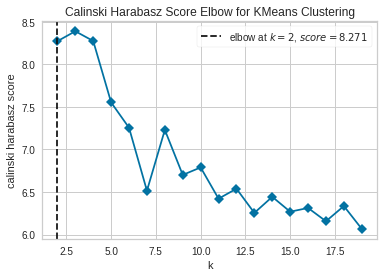

In [30]:
# KElbowvisualizer with metric as 'calinski_harabasz'

model = KMeans(init="k-means++",max_iter=300,random_state=0)
visualizer = KElbowVisualizer(model, k=(2,20),metric= 'calinski_harabasz', timings= False, locate_elbow= True)

visualizer.fit(X)    # Fit the data to the visualizer
visualizer.poof()

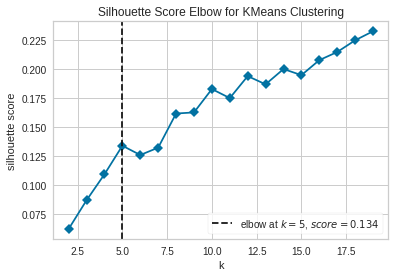

In [31]:
# # KElbowvisualizer with metric as 'silhouette'
model = KMeans(init="k-means++",max_iter=300,random_state=0)
visualizer = KElbowVisualizer(model, k=(2,20), metric='silhouette', timings=False, locate_elbow=True)

visualizer.fit(X)    # Fit the data to the visualizer
visualizer.poof()

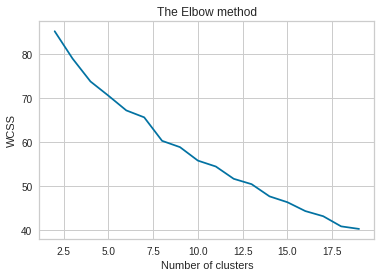

In [32]:
# Eblow method
wcss = []
for i in range(2,20):
  kmeans = KMeans(n_clusters =i,init='k-means++',random_state=0)
  kmeans.fit(X)
  wcss.append(kmeans.inertia_)

plt.plot(range(2,20),wcss)
plt.title('The Elbow method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

In [33]:
# looks like we can go with k clusters.

kmeans= KMeans(n_clusters=26, init= 'k-means++',max_iter=300, n_init=1,random_state = 0)

kmeans.fit(X)

KMeans(n_clusters=26, n_init=1, random_state=0)

In [34]:
#predict the labels of clusters.
labels = kmeans.fit_predict(X)

In [35]:
# Clusters center
clusters_center = kmeans.cluster_centers_

In [36]:
# clusters_center

In [37]:
# test a new text

X_new= vectorizer.transform([df['Cuisines'][26]])

y_pred_new= kmeans.predict(X_new)[0]

y_pred_new

1

In [38]:
# Silhouette score is for model validation for K-means,Hierarichical clustering.
# Silhouette Coefficient ranges between -1 to +1.
# Higher the Silhouette Coefficient better the clustering.

In [39]:
# Model Validation
# silhouette score of my clusters
print("Silhouette Coefficient: %0.3f"%silhouette_score(X, kmeans.labels_))

Silhouette Coefficient: 0.250


In [40]:
# Evaluation
# range_n_clusters = [11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26]
range_n_clusters = [ 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26]
for n_clusters in range_n_clusters:
    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", round(silhouette_avg,5))

For n_clusters = 6 The average silhouette_score is : 0.14117
For n_clusters = 7 The average silhouette_score is : 0.15739
For n_clusters = 8 The average silhouette_score is : 0.16079
For n_clusters = 9 The average silhouette_score is : 0.16655
For n_clusters = 10 The average silhouette_score is : 0.16542
For n_clusters = 11 The average silhouette_score is : 0.18035
For n_clusters = 12 The average silhouette_score is : 0.17849
For n_clusters = 13 The average silhouette_score is : 0.18703
For n_clusters = 14 The average silhouette_score is : 0.19521
For n_clusters = 15 The average silhouette_score is : 0.21263
For n_clusters = 16 The average silhouette_score is : 0.20445
For n_clusters = 17 The average silhouette_score is : 0.20834
For n_clusters = 18 The average silhouette_score is : 0.20917
For n_clusters = 19 The average silhouette_score is : 0.24654
For n_clusters = 20 The average silhouette_score is : 0.2399
For n_clusters = 21 The average silhouette_score is : 0.24824
For n_cluster

In [41]:
# Creating new feature to store labels
df['Cluster_labels'] = kmeans.labels_

In [42]:
# Counting the number of cuisines with each labels
pd.DataFrame(df.groupby(['Cluster_labels'])['Cuisines'].count()).reset_index()

,Cluster_labels,Cuisines
0,0,4
1,1,13
2,2,7
3,3,4
4,4,5
5,5,1
6,6,1
7,7,3
8,8,5
9,9,6


In [43]:
# Getting terms
terms = vectorizer.get_feature_names()

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [44]:
len(terms)

50

In [45]:
# Top terms(words) per cluster
print("Top terms per cluster:")
order_centroids = kmeans.cluster_centers_.argsort()[:, ::-1]
for i in range(26):
    print("Cluster %d:" % i, end='')
    for ind in order_centroids[i, :10]:
        print(' %s' % terms[ind], end='')
        print()

Top terms per cluster:
Cluster 0: andhra
 biryani
 northindian
 chinese
 hyderabadi
 southindian
 chines
 cafe
 fingerfood
 fastfood
Cluster 1: italian
 continental
 northindian
 asian
 chinese
 salad
 fingerfood
 modernindian
 mexican
 spanish
Cluster 2: fastfood
 pizza
 northindian
 burger
 salad
 chinese
 chines
 biryani
 american
 dessert
Cluster 3: biryani
 chines
 northindian
 wraps
 cafe
 fingerfood
 fastfood
 european
 desserts
 dessert
Cluster 4: continent
 northindian
 chinese
 healthyfood
 goan
 fingerfood
 fastfood
 european
 dessert
 continental
Cluster 5: dessert
 fastfood
 biryani
 wraps
 cafe
 goan
 fingerfood
 european
 desserts
 continental
Cluster 6: burger
 kebab
 northindian
 cafe
 fingerfood
 fastfood
 european
 desserts
 dessert
 continental
Cluster 7: northindian
 chinese
 chines
 continent
 southindian
 desserts
 mediterranean
 sushi
 salad
 burger
Cluster 8: desserts
 fastfood
 cafe
 beverag
 bakery
 beverages
 burger
 dessert
 healthyfood
 goan
Cluster 9: chi

In [46]:
df[df['Cluster_labels'] == 1]

,Name,Links,Cost,Cuisines,Timings,Cluster_labels
5,The Fisherman's Wharf,httpswwwzomatocomhyderabadthefishermanswharfga...,"1,500",seafood goan northindian continental asian,12noon to 330pm 4pm to 630pm 7pm to 1130pm mon...,1
13,The Lal Street - Bar Exchange,httpswwwzomatocomhyderabadthelalstreetbarexcha...,"1,300",northindian italian fingerfood,12noon to 12midnight monsun,1
26,Mustang Terrace Lounge,httpswwwzomatocomhyderabadmustangterracelounge...,"1,300",mexican italian northindian chinese salad,12 noon to 1130 pm monwed 12 noon to 1 am fris...,1
38,The Glass Onion,httpswwwzomatocomhyderabadtheglassoniongachibowli,"1,200",northindian continental italian asian,12noon to 11pm mon tue wed thu sun 12noon to 1...,1
40,Frio Bistro,httpswwwzomatocomhyderabadfriobistrogachibowli,"1,200",european italian continental spanish,12noon to 11pm monsun,1
53,Diners Pavilion,httpswwwzomatocomhyderabaddinerspaviliongachib...,"1,200",chinese continental italian,12noon to 430pm 630pm to 1130pm mon tue wed fr...,1
56,Feast - Sheraton Hyderabad Hotel,httpswwwzomatocomhyderabadfeastsheratonhyderab...,"2,500",modernindian asian continental italian,630am to 1030am 1230pm to 3pm 7pm to 11pm mon6...,1
60,PourHouse7,httpswwwzomatocomhyderabadpourhouse7gachibowli,"1,200",northindian continental chinese italian,12 noon to 12 midnight monthu sun 12 noon to 1...,1
61,Prism Club & Kitchen,httpswwwzomatocomhyderabadprismclubkitchengach...,"1,200",kebab continental italian northindian,5pm to 12midnight monsun,1
68,The Tilt Bar Republic,httpswwwzomatocomthetiltbarrepublic,"1,500",northindian continental italian,12noon to 12midnight monsun,1


In [47]:
# Replacing ',' 
df['Cost'] = df['Cost'].str.replace(',','')

# Converting 'cost' feature to integer datatype
df['Cost'] = df['Cost'].apply(lambda x:int(x))
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 104 entries, 0 to 104
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Name            104 non-null    object
 1   Links           104 non-null    object
 2   Cost            104 non-null    int64 
 3   Cuisines        104 non-null    object
 4   Timings         104 non-null    object
 5   Cluster_labels  104 non-null    int32 
dtypes: int32(1), int64(1), object(4)
memory usage: 9.4+ KB


In [48]:
# Installing inflect library
pip install inflect

SyntaxError: ignored

In [49]:
# Creating an instance for converting number to words
p = inflect.engine()

In [50]:
# Appling number to words to 'Cost' feature
df['Cost'] = df['Cost'].apply(lambda x: p.number_to_words(x) )

In [51]:
df['Cost'] = df['Cost'].str.replace(',','')
df['Cost'] = df['Cost'].str.replace(' ','')

In [52]:
df.head()

,Name,Links,Cost,Cuisines,Timings,Cluster_labels
0,Beyond Flavours,httpswwwzomatocomhyderabadbeyondflavoursgachib...,eighthundred,chinese continental kebab european southindian...,12noon to 330pm 630pm to 1130pm monsun,16
1,Paradise,httpswwwzomatocomhyderabadparadisegachibowli,eighthundred,biryani northindian chines,11 am to 11 pm,3
2,Flechazo,httpswwwzomatocomhyderabadflechazogachibowli,onethousandthreehundred,asian mediterranean northindian dessert,1130 am to 430 pm 630 pm to 11 pm,13
3,Shah Ghouse Hotel & Restaurant,httpswwwzomatocomhyderabadshahghousehotelresta...,eighthundred,biryani northindian chinese seafood beverag,12 noon to 2 am,19
4,Over The Moon Brew Company,httpswwwzomatocomhyderabadoverthemoonbrewcompa...,onethousandtwohundred,asian continental northindian chinese mediterr...,12noon to 11pm mon tue wed thu sun 12noon to 1...,13


In [53]:
df['costncuisine'] = df['Cost'] +' '+ df['Cuisines']

In [54]:
df.head()

,Name,Links,Cost,Cuisines,Timings,Cluster_labels,costncuisine
0,Beyond Flavours,httpswwwzomatocomhyderabadbeyondflavoursgachib...,eighthundred,chinese continental kebab european southindian...,12noon to 330pm 630pm to 1130pm monsun,16,eighthundred chinese continental kebab europea...
1,Paradise,httpswwwzomatocomhyderabadparadisegachibowli,eighthundred,biryani northindian chines,11 am to 11 pm,3,eighthundred biryani northindian chines
2,Flechazo,httpswwwzomatocomhyderabadflechazogachibowli,onethousandthreehundred,asian mediterranean northindian dessert,1130 am to 430 pm 630 pm to 11 pm,13,onethousandthreehundred asian mediterranean no...
3,Shah Ghouse Hotel & Restaurant,httpswwwzomatocomhyderabadshahghousehotelresta...,eighthundred,biryani northindian chinese seafood beverag,12 noon to 2 am,19,eighthundred biryani northindian chinese seafo...
4,Over The Moon Brew Company,httpswwwzomatocomhyderabadoverthemoonbrewcompa...,onethousandtwohundred,asian continental northindian chinese mediterr...,12noon to 11pm mon tue wed thu sun 12noon to 1...,13,onethousandtwohundred asian continental northi...


In [55]:
# Applying kmeans for feature 'Costncuisine' 
# Costncusine = concatenation of cost and cuisine

In [56]:
# Tfidf vectorizer
vectorizer = TfidfVectorizer(stop_words= 'english')
X_costncuisine = vectorizer.fit_transform(df['costncuisine'])

In [57]:
X_costncuisine.shape
# we have 50 unique words

(104, 79)

In [58]:
# Type of X object
type(X_costncuisine)

scipy.sparse.csr.csr_matrix

In [59]:
# Converting 'X' object to array
X_costncuisine = X_costncuisine.toarray()

In [60]:
type(X_costncuisine)

numpy.ndarray

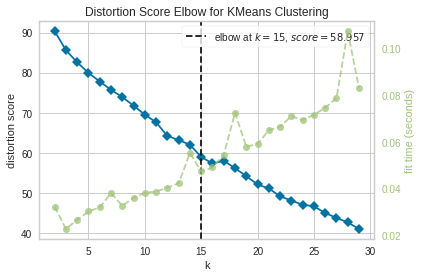

In [61]:
# KElbowvisualizer with metric as 'distortion

model = KMeans(init="k-means++",max_iter=300,random_state=0)
visualizer = KElbowVisualizer(model, k=(2,30),metric= 'distortion', timings= True, locate_elbow= True)

visualizer.fit(X_costncuisine)    # Fit the data to the visualizer
visualizer.poof()

In [62]:
# Evaluation
# range_n_clusters = [11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26]
range_n_clusters = [ 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26]
for n_clusters in range_n_clusters:
    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X_costncuisine)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X_costncuisine, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", round(silhouette_avg,5))

For n_clusters = 6 The average silhouette_score is : 0.06014
For n_clusters = 7 The average silhouette_score is : 0.05674
For n_clusters = 8 The average silhouette_score is : 0.06494
For n_clusters = 9 The average silhouette_score is : 0.07857
For n_clusters = 10 The average silhouette_score is : 0.0811
For n_clusters = 11 The average silhouette_score is : 0.08713
For n_clusters = 12 The average silhouette_score is : 0.08796
For n_clusters = 13 The average silhouette_score is : 0.10574
For n_clusters = 14 The average silhouette_score is : 0.09965
For n_clusters = 15 The average silhouette_score is : 0.11555
For n_clusters = 16 The average silhouette_score is : 0.09652
For n_clusters = 17 The average silhouette_score is : 0.11121
For n_clusters = 18 The average silhouette_score is : 0.10708
For n_clusters = 19 The average silhouette_score is : 0.12528
For n_clusters = 20 The average silhouette_score is : 0.12298
For n_clusters = 21 The average silhouette_score is : 0.12796
For n_cluster

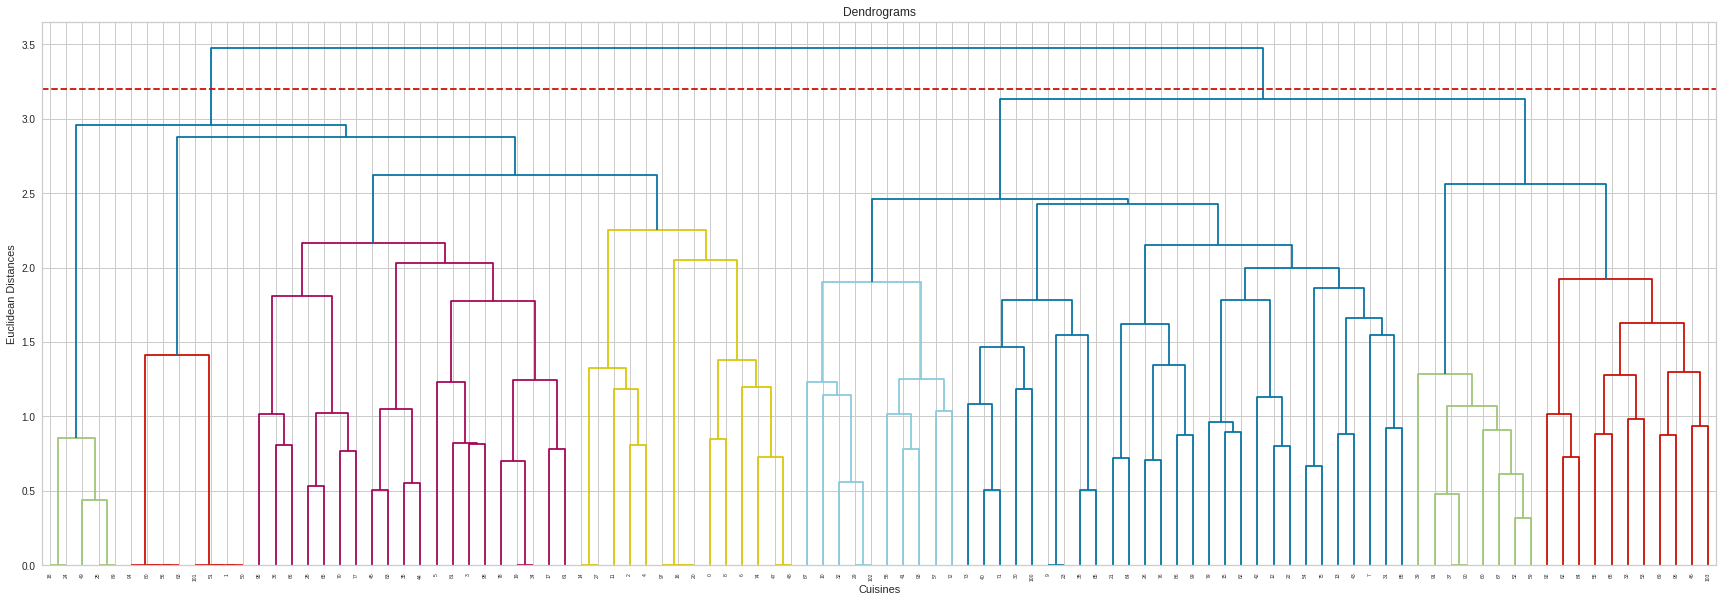

In [63]:
# Hierarchical Clustering

plt.figure(figsize=(30,10))
dend = shc.dendrogram(shc.linkage(X, method='ward'))
plt.title("Dendrograms")
plt.xlabel('Cuisines')
plt.ylabel('Euclidean Distances')
plt.axhline(y=3.2, color='r', linestyle='--')
plt.show()

In [64]:
# AgglomerativeClustering

for k in range(2,20):
  aggh = AgglomerativeClustering(n_clusters=k, affinity='euclidean', linkage='ward')  
  aggh.fit(X)
  y_hc=aggh.fit_predict(X)
  # print("Silhouette Coefficient for : %0.3f"%silhouette_score(X, y_hc))
  print("For n_clusters =", k, "The average silhouette_score is :", round(silhouette_score(X, y_hc),5))

For n_clusters = 2 The average silhouette_score is : 0.06304
For n_clusters = 3 The average silhouette_score is : 0.07949
For n_clusters = 4 The average silhouette_score is : 0.1068
For n_clusters = 5 The average silhouette_score is : 0.10474
For n_clusters = 6 The average silhouette_score is : 0.11906
For n_clusters = 7 The average silhouette_score is : 0.12565
For n_clusters = 8 The average silhouette_score is : 0.12826
For n_clusters = 9 The average silhouette_score is : 0.13974
For n_clusters = 10 The average silhouette_score is : 0.15252
For n_clusters = 11 The average silhouette_score is : 0.16091
For n_clusters = 12 The average silhouette_score is : 0.17093
For n_clusters = 13 The average silhouette_score is : 0.18888
For n_clusters = 14 The average silhouette_score is : 0.19819
For n_clusters = 15 The average silhouette_score is : 0.20475
For n_clusters = 16 The average silhouette_score is : 0.20966
For n_clusters = 17 The average silhouette_score is : 0.21066
For n_clusters = 